## Importing Packages

In [97]:
import warnings
warnings.filterwarnings("ignore")
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from datetime import date
import seaborn as sns
from pydataset import data
from env import host, user, password
from sklearn.model_selection import train_test_split
import os
from sklearn.cluster import KMeans
from wrangle_zillow import wrangle_zillow, split_zillow, scale_data
import re
import PyPDF2
from FE_cluster import select_kbest
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

## Acquiring Clean Data

In [2]:
zillow = wrangle_zillow()

## Splitting the Data

In [3]:
train, validate, test = split_zillow(zillow, stratify_by = 'county')

## Explore

<AxesSubplot:xlabel='logerror_absolute', ylabel='Count'>

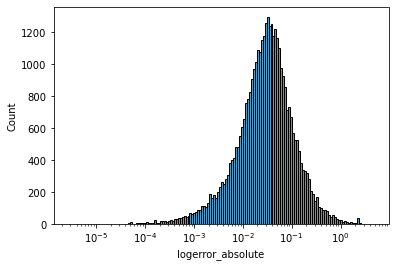

In [4]:
# Displaying a distribution of absolute logerror on a logarithmic scale to see all data points

sns.histplot(train['logerror_absolute'], log_scale = True)

<AxesSubplot:xlabel='lotsizesquarefeet', ylabel='Count'>

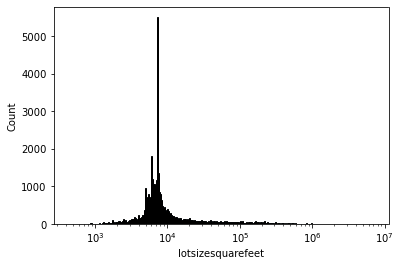

In [5]:
# Displaying lot square footage distribution

sns.histplot(train['lotsizesquarefeet'], log_scale = True)

<AxesSubplot:xlabel='square_feet', ylabel='Count'>

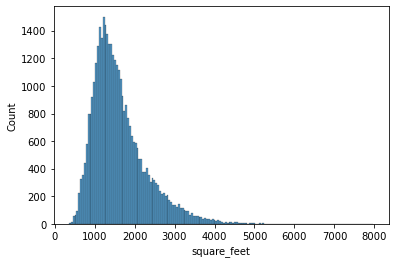

In [6]:
# Displaying property square footage distribution

sns.histplot(train['square_feet'])

<AxesSubplot:xlabel='bathrooms', ylabel='Count'>

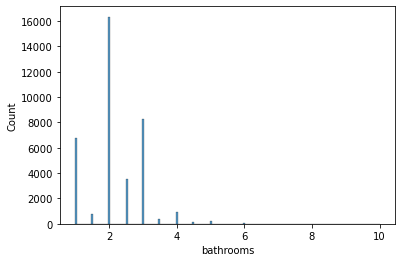

In [7]:
# Displaying a distribution of bathrooms

sns.histplot(train['bathrooms'])

<AxesSubplot:xlabel='county', ylabel='logerror'>

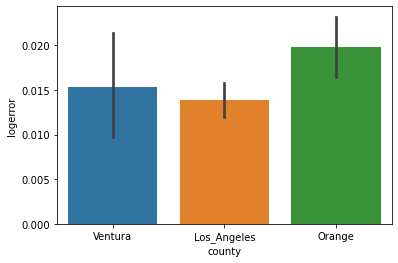

In [8]:
# Displaying the relationship between county and logerror
# Orange county has a significantly higher average error than the other counties, although this is average
# including over/under estimates. If we want an idea of total deviation from the true value of the property
# we have to use an absolute error to measure deviations from the true value.

sns.barplot(x = train['county'], y = train['logerror'])

<AxesSubplot:xlabel='county', ylabel='logerror_absolute'>

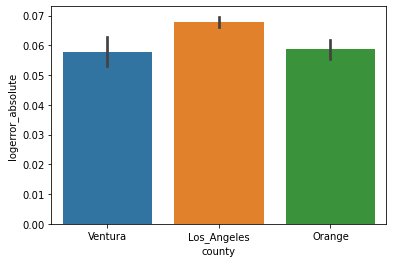

In [9]:
# Displaying the relationship between county and their relative absolute logerror
# Los Angeles seems to have a higher average absolute logerror. So estimates are least reliable when coming
# from LA. While this is useful information for reliability of estimations, as a predictor it doesn't provide
# much insight.

sns.barplot(x = train['county'], y = train['logerror_absolute'])

<AxesSubplot:xlabel='square_feet', ylabel='logerror'>

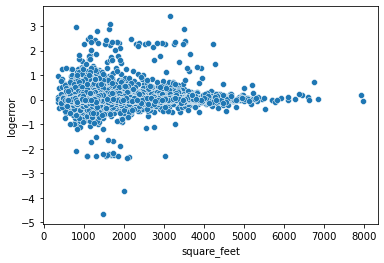

In [10]:
# Displaying relationship between square footage and logerror
# Note as square footage increases total error seems to go down

sns.scatterplot(x = train['square_feet'], y = train['logerror'])

<AxesSubplot:xlabel='tax_value', ylabel='logerror'>

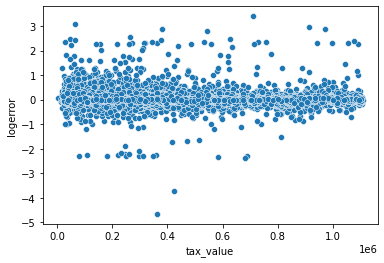

In [11]:
# Displaying relationship between square footage and logerror
# Doesn't seem to be much of a relationship here

sns.scatterplot(x = train['tax_value'], y = train['logerror'])

<AxesSubplot:xlabel='tax_rate', ylabel='logerror'>

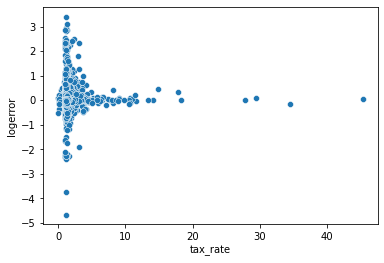

In [12]:
# Displaying relationship between tax rate and logerror
# Looks as though as tax rate increases so does accuracy, although let's see if those are just outliers

sns.scatterplot(x = train['tax_rate'], y = train['logerror'])

<AxesSubplot:xlabel='tax_rate'>

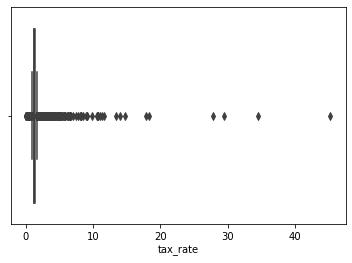

In [13]:
# Yeah those are outliers

sns.boxplot(train['tax_rate'])

<AxesSubplot:xlabel='buildingqualitytypeid', ylabel='logerror'>

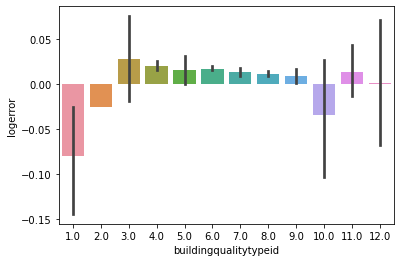

In [14]:
# Displaying relationship between building quality type and logerror

sns.barplot(x = train['buildingqualitytypeid'], y = train['logerror'])

<AxesSubplot:xlabel='age_in_years', ylabel='logerror'>

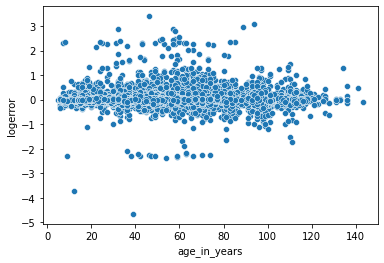

In [16]:
# Age in years and logerror, not much of a relaationship between the two

sns.scatterplot(x = train['age_in_years'], y = train['logerror'])

<AxesSubplot:xlabel='bathrooms', ylabel='logerror'>

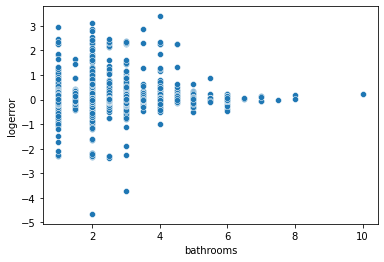

In [17]:
# Displaying logerror and bathrooms, it seems as though when the properties get larger/more expensive,
# the log error seems to move towards 0.

sns.scatterplot(x = train['bathrooms'], y = train['logerror'])

## Test 1

Is there a significant difference in the average error of Orange County and the total average error? (alpha = .05)

In [18]:
x1 = train[train['county'] == 'Orange']
x1 = x1['logerror']
x2 = train.logerror.mean()
t, p = stats.ttest_1samp(x1, x2)

print(f't = {t:.3f}')
print(f'p = {p:.3f}')

t = 2.452
p = 0.014


With a p-value falling below my set alpha, we can reasonably say there is a significant difference in the average logerror between Orange county and the average.

## Test 2

Is there a difference in the average log error between houses that are greater than 2500 feet and those that are less? (alpha = .05)

In [92]:
x1 = train[train['square_feet'] < 2500]
x1 = x1['logerror']
x2 = train[train['square_feet'] > 2500]
x2 = x2['logerror']
t, p = stats.ttest_ind(x1, x2)

print(f't = {t:.3f}')
print(f'p = {p:.3f}')

t = -7.773
p = 0.000


With a p-value falling below my set alpha, we can reasonably say there is a significant difference in the average logerror between properties with greater than 2500 square feet and those with less.

## Test 3

Is there a difference in the average log error between houses that have more than 4 bathrooms and those that have 4 or less? (alpha = .05)

In [20]:
x1 = train[train['bathrooms'] <= 4]
x1 = x1['logerror']
x2 = train[train['square_feet'] > 4]
x2 = x2['logerror']
t, p = stats.ttest_ind(x1, x2)

print(f't = {t:.3f}')
print(f'p = {p:.3f}')

t = -0.301
p = 0.763


With a p-value above my alpha, we can say that there is likely no significant difference in logerror between properties with more than 4 bathrooms and those with 4 or less.

## Adding > 2500 sqft feature

In [21]:
train['greater_than_2500_sqft'] = train.square_feet.apply(lambda x: 1 if x > 2500 else 0)
validate['greater_than_2500_sqft'] = validate.square_feet.apply(lambda x: 1 if x > 2500 else 0)
test['greater_than_2500_sqft'] = test.square_feet.apply(lambda x: 1 if x > 2500 else 0)

## Feature Engineering

Finding features most associated with logerror for use in clusters

In [91]:
feature_train = train.select_dtypes(include=['float64', 'int64', 'uint8'])
select_kbest(feature_train.drop(columns=['logerror']), feature_train['logerror'], 5)

['bathrooms',
 'bedrooms',
 'square_feet',
 'greater_than_2500_sqft',
 'county_Orange']

## Prepping and Scaling for Clustering/Modeling

In [23]:
# Making dummies for Orange county

dummies_orange = pd.get_dummies(train[['county']])
train = pd.concat([train, dummies_orange], axis=1)
train.drop(columns = ['county_Los_Angeles', 'county_Ventura'], inplace = True)
dummies_orange = pd.get_dummies(validate[['county']])
validate = pd.concat([validate, dummies_orange], axis=1)
validate.drop(columns = ['county_Los_Angeles', 'county_Ventura'], inplace = True)
dummies_orange = pd.get_dummies(test[['county']])
test = pd.concat([test, dummies_orange], axis=1)
test.drop(columns = ['county_Los_Angeles', 'county_Ventura'], inplace = True)

In [24]:
# Dropping unnecessary columns that provide no insight for the models, redundant columns as well

train.drop(columns = ['parcelid', 'transactiondate', 'fips','rawcensustractandblock', 'regionidcity',
                      'regionidcounty', 'regionidzip', 'yearbuilt', 'assessmentyear', 'logerror_absolute', 
                      'county', 'heatingorsystemdesc', 'Bedrooms_cat', 'Bathrooms_cat', 
                      'unitcnt', 'roomcnt', 'buildingqualitytypeid', 'landtaxvaluedollarcnt', 
                      'latitude', 'longitude'], inplace = True)
validate.drop(columns = ['parcelid', 'transactiondate', 'fips','rawcensustractandblock', 'regionidcity',
                      'regionidcounty', 'regionidzip', 'yearbuilt', 'assessmentyear', 'logerror_absolute', 
                      'county', 'heatingorsystemdesc', 'Bedrooms_cat', 'Bathrooms_cat', 
                      'unitcnt', 'roomcnt', 'buildingqualitytypeid', 'landtaxvaluedollarcnt', 
                      'latitude', 'longitude'], inplace = True)
test.drop(columns = ['parcelid', 'transactiondate', 'fips','rawcensustractandblock', 'regionidcity',
                      'regionidcounty', 'regionidzip', 'yearbuilt', 'assessmentyear', 'logerror_absolute', 
                      'county', 'heatingorsystemdesc', 'Bedrooms_cat', 'Bathrooms_cat', 
                      'unitcnt', 'roomcnt', 'buildingqualitytypeid', 'landtaxvaluedollarcnt', 
                      'latitude', 'longitude'], inplace = True)

In [25]:
# Scaling the data using a standard scaler

train_scale, validate_scale, test_scale = scale_data(train, validate, test)
train.index = train_scale.index
validate.index = validate_scale.index
test.index = test_scale.index

In [26]:
# Resetting the "logerror" to not be scaled

train_scale['logerror'] = train['logerror']
validate_scale['logerror'] = validate['logerror']
test_scale['logerror'] = test['logerror']

## Creating first series of clusters

In [27]:
# First series of clusters are based on feature engineering of those features most associated with logerror
# skipping features that were more redundant.

X = train_scale[['county_Orange', 'bathrooms', 'greater_than_2500_sqft']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
kmeans.predict(X)

X_val = validate_scale[['county_Orange', 'bathrooms', 'greater_than_2500_sqft']]
validate_scale['cluster1'] = kmeans.predict(X_val)

X_test = test_scale[['county_Orange', 'bathrooms', 'greater_than_2500_sqft']]
test_scale['cluster1'] = kmeans.predict(X_test)

In [28]:
# Finding centroids for first cluster series

train_scale['cluster1'] = kmeans.predict(X)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)

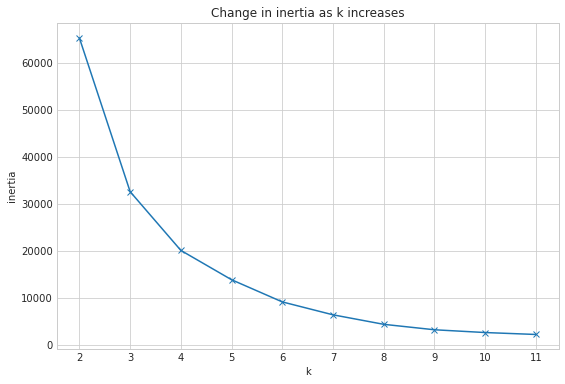

In [29]:
# Finding optimal number of clusters with given features (elbow looks as though it could be around 4)

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

<AxesSubplot:xlabel='bathrooms', ylabel='greater_than_2500_sqft'>

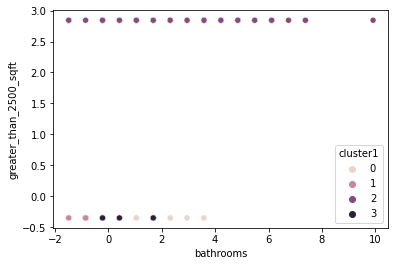

In [30]:
# Displaying bathrooms by greater than 2500 square feet and coloring by cluster to see cluster distribution

sns.scatterplot(data = train_scale, x = 'bathrooms', y = 'greater_than_2500_sqft', hue = 'cluster1')

<AxesSubplot:xlabel='county_Orange', ylabel='logerror'>

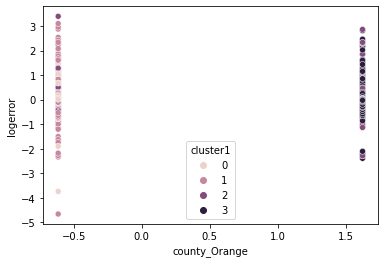

In [31]:
# Displaying logerror by Orange county and colored by cluster.

sns.scatterplot(data = train_scale, x = 'county_Orange', y = 'logerror', hue = 'cluster1')

In [32]:
centroids

,county_Orange,bathrooms,greater_than_2500_sqft
0,-0.613979,1.024926,-0.351494
1,-0.615428,-0.623332,-0.351494
2,0.149119,1.425459,2.844996
3,1.624885,-0.093075,-0.351494


### The clusters seem to have the following descriptions:
    0: Mostly not Orange county, lower square footage, large number of bathrooms
    1: Majority Orange county, lower square footage, average number of bathrooms
    2: Pretty even spread by county, high square footage, high number of bathrooms, high square footage
    3: Mostly not Orange county, lower square footage, small amount of bathrooms

## Creating second series of clusters

In [33]:
# Second series of clusters created using features that would seem to have no relationship

X = train_scale[['tax_rate', 'age_in_years', 'square_feet']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
kmeans.predict(X)

X_val = validate_scale[['tax_rate', 'age_in_years', 'square_feet']]
validate_scale['cluster2'] = kmeans.predict(X_val)

X_test = test_scale[['tax_rate', 'age_in_years', 'square_feet']]
test_scale['cluster2'] = kmeans.predict(X_test)

In [34]:
# Creating centroids

train_scale['cluster2'] = kmeans.predict(X)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)

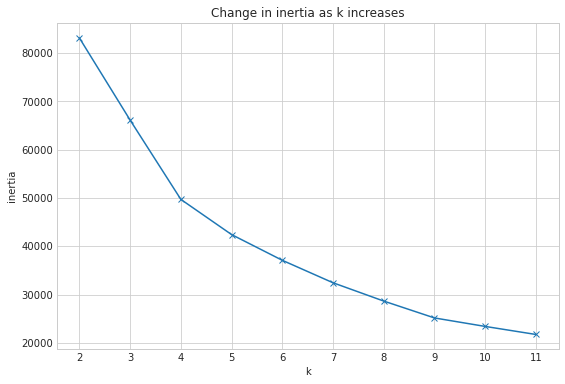

In [35]:
# Finding optimal number of clusters with given features (elbow at 4)



with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

<AxesSubplot:xlabel='age_in_years', ylabel='square_feet'>

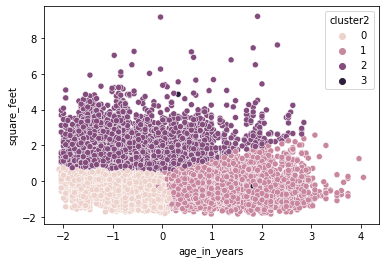

In [36]:
# Displaying age and square footage colored by clusters

sns.scatterplot(data = train_scale, x = 'age_in_years', y = 'square_feet', hue = 'cluster2')

<AxesSubplot:xlabel='square_feet', ylabel='logerror'>

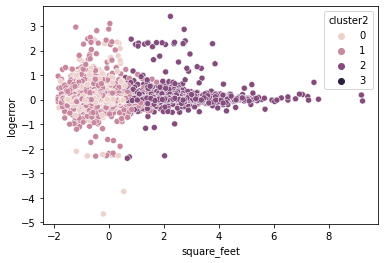

In [37]:
# Displaying square footage and logerror while coloring by cluster, clusters seem more dependent on age 
# and square feet

sns.scatterplot(data = train_scale, x = 'square_feet', y = 'logerror', hue = 'cluster2')

<AxesSubplot:xlabel='tax_rate', ylabel='logerror'>

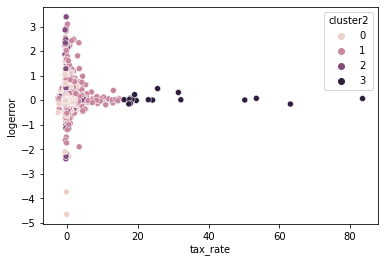

In [38]:
# Tax rate and logerror, it seems one of my clusters is simply tax rate outliers

sns.scatterplot(data = train_scale, x = 'tax_rate', y = 'logerror', hue = 'cluster2')

<AxesSubplot:xlabel='tax_rate', ylabel='square_feet'>

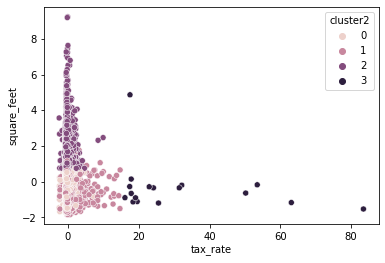

In [39]:
# Square footage and tax rate

sns.scatterplot(data = train_scale, x = 'tax_rate', y = 'square_feet', hue = 'cluster2')

In [40]:
centroids

,tax_rate,age_in_years,square_feet
0,-0.092407,-0.706245,-0.388055
1,0.107680,0.927180,-0.380234
2,-0.114265,-0.539191,1.592898
3,31.210671,1.035814,-0.349074


### Clusters seem to have the following descriptions:
    0: moderate tax rate, old, low square feet
    1: high tax rate, old, low square feet
    2: moderate tax rate, young, high square footage
    3: moderate tax rate, very young, low square feet

## Final prep for modeling

In [41]:
# Further splitting for linear regression

x_train = train_scale.drop(columns = ['logerror'])
y_train = train_scale['logerror']

x_validate = validate_scale.drop(columns = ['logerror'])
y_validate = validate_scale['logerror']

x_test = test_scale.drop(columns = ['logerror'])
y_test = test_scale['logerror']

In [113]:
# List of features used for modeling outside of cluster columns

features = x_train.columns.tolist()
res = features[: -2]
res

['bathrooms',
 'bedrooms',
 'square_feet',
 'lotsizesquarefeet',
 'structuretaxvaluedollarcnt',
 'tax_value',
 'taxes',
 'age_in_years',
 'tax_rate',
 'greater_than_2500_sqft',
 'county_Orange']

## Establishing baselines

In [42]:
# Using average and median to predict logerror to establish a baseline for my models

y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# Establishing mean
zillow_pred_mean = y_train['logerror'].mean()
y_train['zillow_pred_mean'] = zillow_pred_mean
y_validate['zillow_pred_mean'] = zillow_pred_mean

# Establishing median
zillow_pred_median = y_train['logerror'].median()
y_train['zillow_pred_median'] = zillow_pred_median
y_validate['zillow_pred_median'] = zillow_pred_median

# RMSE of mean
rmse_train = mean_squared_error(y_train.logerror, y_train.zillow_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.zillow_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 5), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 5))

# 4. RMSE of median
rmse_train = mean_squared_error(y_train.logerror, y_train.zillow_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.zillow_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 5), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 5))

RMSE using Mean
Train/In-Sample:  0.15672 
Validate/Out-of-Sample:  0.15877
RMSE using Median
Train/In-Sample:  0.157 
Validate/Out-of-Sample:  0.15906


# Cluster 1

## Linear Regression

In [103]:
# Making the model

lin_reg = LinearRegression(normalize = True)

# Fitting the model

lin_reg.fit(x_train.drop(columns =['cluster2']), y_train['logerror'])

# Using the model

y_train['error_pred_lm'] = lin_reg.predict(x_train.drop(columns =['cluster2']))
rmse_train = mean_squared_error(y_train['logerror'], y_train.error_pred_lm)**(1/2)

y_validate['error_pred_lm'] = lin_reg.predict(x_validate.drop(columns =['cluster2']))
rmse_validate = mean_squared_error(y_validate['logerror'], y_validate.error_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", round(rmse_train, 5), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate, 5))

RMSE for OLS using LinearRegression
Training/In-Sample:  0.15638 
Validation/Out-of-Sample:  0.15858


## LassoLars

In [44]:
# Making the model

lars = LassoLars(alpha=1.0)

# Fitting the model
lars.fit(x_train.drop(columns =['cluster2']), y_train['logerror'])

# Using the model

y_train['value_pred_lars'] = lars.predict(x_train.drop(columns =['cluster2']))
rmse_train = mean_squared_error(y_train['logerror'], y_train.value_pred_lars)**(1/2)

y_validate['value_pred_lars'] = lars.predict(x_validate.drop(columns =['cluster2']))
rmse_validate = mean_squared_error(y_validate['logerror'], y_validate.value_pred_lars)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", round(rmse_train, 5), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate, 5))

RMSE for OLS using LinearRegression
Training/In-Sample:  0.15672 
Validation/Out-of-Sample:  0.15877


## Polynomial Regression

In [45]:
# Making the model

pf = PolynomialFeatures(degree=2)

# Transforming features

x_train_degree2 = pf.fit_transform(x_train.drop(columns =['cluster2']))
x_validate_degree2 = pf.transform(x_validate.drop(columns =['cluster2']))

In [46]:
# Fitting the model

lm2 = LinearRegression(normalize=True)
lm2.fit(x_train_degree2, y_train['logerror'])

# Using the model
y_train['value_pred_lm2'] = lm2.predict(x_train_degree2)
rmse_train = mean_squared_error(y_train['logerror'], y_train.value_pred_lm2)**(1/2)

y_validate['value_pred_lm2'] = lm2.predict(x_validate_degree2)
rmse_validate = mean_squared_error(y_validate['logerror'], y_validate.value_pred_lm2)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", round(rmse_train, 5), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate, 5))

RMSE for OLS using LinearRegression
Training/In-Sample:  0.156 
Validation/Out-of-Sample:  0.1589


# Cluster 2

## Linear Regression

In [47]:
# Making the model

lin_reg = LinearRegression(normalize = True)

# Fitting the model

lin_reg.fit(x_train.drop(columns =['cluster1']), y_train['logerror'])

# Using the model

y_train['error_pred_lm'] = lin_reg.predict(x_train.drop(columns =['cluster1']))
rmse_train = mean_squared_error(y_train['logerror'], y_train.error_pred_lm)**(1/2)

y_validate['error_pred_lm'] = lin_reg.predict(x_validate.drop(columns =['cluster1']))
rmse_validate = mean_squared_error(y_validate['logerror'], y_validate.error_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", round(rmse_train, 5), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate, 5))

RMSE for OLS using LinearRegression
Training/In-Sample:  0.15639 
Validation/Out-of-Sample:  0.15858


## LassoLars

In [48]:
# Making the model

lars = LassoLars(alpha=1.0)

# Fitting the model

lars.fit(x_train.drop(columns =['cluster1']), y_train['logerror'])

# Using the model

y_train['value_pred_lars'] = lars.predict(x_train.drop(columns =['cluster1']))
rmse_train = mean_squared_error(y_train['logerror'], y_train.value_pred_lars)**(1/2)

y_validate['value_pred_lars'] = lars.predict(x_validate.drop(columns =['cluster1']))
rmse_validate = mean_squared_error(y_validate['logerror'], y_validate.value_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", round(rmse_train, 5), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate, 5))

RMSE for Lasso + Lars
Training/In-Sample:  0.15672 
Validation/Out-of-Sample:  0.15877


## Polynomial Regression

In [49]:
# Making the model

pf = PolynomialFeatures(degree=2)

# Transforming features

x_train_degree2 = pf.fit_transform(x_train.drop(columns =['cluster1']))
x_validate_degree2 = pf.transform(x_validate.drop(columns =['cluster1']))

In [50]:
# Fitting the model

lm2 = LinearRegression(normalize=True)
lm2.fit(x_train_degree2, y_train['logerror'])

# Using the model

y_train['value_pred_lm2'] = lm2.predict(x_train_degree2)
rmse_train = mean_squared_error(y_train['logerror'], y_train.value_pred_lm2)**(1/2)

y_validate['value_pred_lm2'] = lm2.predict(x_validate_degree2)
rmse_validate = mean_squared_error(y_validate['logerror'], y_validate.value_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", round(rmse_train, 5), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate, 5))

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.15599 
Validation/Out-of-Sample:  0.15886


## Organizing by cluster1

In [51]:
train_clust0 = train_scale[train_scale['cluster1'] == 0]
train_clust1 = train_scale[train_scale['cluster1'] == 1]
train_clust2 = train_scale[train_scale['cluster1'] == 2]
train_clust3 = train_scale[train_scale['cluster1'] == 3]

val_clust0 = validate_scale[validate_scale['cluster1'] == 0]
val_clust1 = validate_scale[validate_scale['cluster1'] == 1]
val_clust2 = validate_scale[validate_scale['cluster1'] == 2]
val_clust3 = validate_scale[validate_scale['cluster1'] == 3]

test_clust0 = test_scale[test_scale['cluster1'] == 0]
test_clust1 = test_scale[test_scale['cluster1'] == 1]
test_clust2 = test_scale[test_scale['cluster1'] == 2]
test_clust3 = test_scale[test_scale['cluster1'] == 3]

## Establishing baseline for cluster1 == 0

In [114]:
x_train = train_clust0.drop(columns = ['logerror'])
y_train = train_clust0['logerror']

x_validate = val_clust0.drop(columns = ['logerror'])
y_validate = val_clust0['logerror']

x_test = test_clust0.drop(columns = ['logerror'])
y_test = test_clust0['logerror']

In [115]:
x_train.drop(columns = ['cluster1', 'cluster2'], inplace = True)
x_validate.drop(columns = ['cluster1', 'cluster2'], inplace = True)
x_test.drop(columns = ['cluster1', 'cluster2'], inplace = True)

In [116]:
def run_the_models(x_train, x_validate, y_train, y_validate):
    # Using average and median to predict logerror to establish a baseline for my models
    
    y_train = pd.DataFrame(y_train)
    y_validate = pd.DataFrame(y_validate)
    
    # Establishing mean
    zillow_pred_mean = y_train['logerror'].mean()
    y_train['zillow_pred_mean'] = zillow_pred_mean
    y_validate['zillow_pred_mean'] = zillow_pred_mean
    
    # Establishing median
    zillow_pred_median = y_train['logerror'].median()
    y_train['zillow_pred_median'] = zillow_pred_median
    y_validate['zillow_pred_median'] = zillow_pred_median
    
    # RMSE of mean
    rmse_train_men = mean_squared_error(y_train.logerror, y_train.zillow_pred_mean)**(1/2)
    rmse_validate_men = mean_squared_error(y_validate.logerror, y_validate.zillow_pred_mean)**(1/2)
    
    # 4. RMSE of median
    rmse_train_med = mean_squared_error(y_train.logerror, y_train.zillow_pred_median)**(1/2)
    rmse_validate_med = mean_squared_error(y_validate.logerror, y_validate.zillow_pred_median)**(1/2)
    
    lin_reg = LinearRegression(normalize = True)
    lin_reg.fit(x_train, y_train['logerror'])
    y_train['error_pred_lm'] = lin_reg.predict(x_train)
    rmse_train_lin = mean_squared_error(y_train['logerror'], y_train.error_pred_lm)**(1/2)
    y_validate['error_pred_lm'] = lin_reg.predict(x_validate)
    rmse_validate_lin = mean_squared_error(y_validate['logerror'], y_validate.error_pred_lm)**(1/2)
    evs = explained_variance_score(y_validate['logerror'], y_validate['error_pred_lm'])
    
    lars = LassoLars(alpha=1.0)
    lars.fit(x_train, y_train['logerror'])
    y_train['value_pred_lars'] = lars.predict(x_train)
    rmse_train_las = mean_squared_error(y_train['logerror'], y_train.value_pred_lars)**(1/2)
    y_validate['value_pred_lars'] = lars.predict(x_validate)
    rmse_validate_las = mean_squared_error(y_validate['logerror'], y_validate.value_pred_lars)**(1/2)
    
    
    return print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train_men, 5), 
          "\nValidate/Out-of-Sample: ", round(rmse_validate_men, 5), "\nRMSE using Mean\nTrain/In-Sample: ",
          round(rmse_train_med, 5), "\nValidate/Out-of-Sample: ", round(rmse_validate_med, 5),
          "\nRMSE for OLS using LinearRegression\nTraining/In-Sample: ", round(rmse_train_lin, 5), 
          "\nValidation/Out-of-Sample: ", round(rmse_validate_lin, 5),
          "\nRMSE for Lasso + Lars\nTraining/In-Sample: ", round(rmse_train_las, 5), 
          "\nValidation/Out-of-Sample: ", round(rmse_validate_las, 5))
    
    

## Cluster 0

In [117]:
run_the_models(x_train, x_validate, y_train, y_validate)

RMSE using Median
Train/In-Sample:  0.11305 
Validate/Out-of-Sample:  0.13714 
RMSE using Mean
Train/In-Sample:  0.11316 
Validate/Out-of-Sample:  0.13727 
RMSE for OLS using LinearRegression
Training/In-Sample:  0.11277 
Validation/Out-of-Sample:  0.13742 
RMSE for Lasso + Lars
Training/In-Sample:  0.11305 
Validation/Out-of-Sample:  0.13714


## Cluster 1

In [118]:
x_train = train_clust1.drop(columns = ['logerror'])
y_train = train_clust1['logerror']

x_validate = val_clust1.drop(columns = ['logerror'])
y_validate = val_clust1['logerror']

x_test = test_clust1.drop(columns = ['logerror'])
y_test = test_clust1['logerror']

In [119]:
x_train.drop(columns = ['cluster1', 'cluster2'], inplace = True)
x_validate.drop(columns = ['cluster1', 'cluster2'], inplace = True)
x_test.drop(columns = ['cluster1', 'cluster2'], inplace = True)

In [120]:
run_the_models(x_train, x_validate, y_train, y_validate)

RMSE using Median
Train/In-Sample:  0.15984 
Validate/Out-of-Sample:  0.1545 
RMSE using Mean
Train/In-Sample:  0.16005 
Validate/Out-of-Sample:  0.15473 
RMSE for OLS using LinearRegression
Training/In-Sample:  0.15948 
Validation/Out-of-Sample:  0.15434 
RMSE for Lasso + Lars
Training/In-Sample:  0.15984 
Validation/Out-of-Sample:  0.1545


## Cluster 2

In [121]:
x_train = train_clust2.drop(columns = ['logerror'])
y_train = train_clust2['logerror']

x_validate = val_clust2.drop(columns = ['logerror'])
y_validate = val_clust2['logerror']

x_test = test_clust2.drop(columns = ['logerror'])
y_test = test_clust2['logerror']

In [122]:
x_train.drop(columns = ['cluster1', 'cluster2'], inplace = True)
x_validate.drop(columns = ['cluster1', 'cluster2'], inplace = True)
x_test.drop(columns = ['cluster1', 'cluster2'], inplace = True)

In [123]:
run_the_models(x_train, x_validate, y_train, y_validate)

RMSE using Median
Train/In-Sample:  0.19638 
Validate/Out-of-Sample:  0.20465 
RMSE using Mean
Train/In-Sample:  0.19738 
Validate/Out-of-Sample:  0.20519 
RMSE for OLS using LinearRegression
Training/In-Sample:  0.19572 
Validation/Out-of-Sample:  0.2052 
RMSE for Lasso + Lars
Training/In-Sample:  0.19638 
Validation/Out-of-Sample:  0.20465


## Cluster 3

In [124]:
x_train = train_clust3.drop(columns = ['logerror'])
y_train = train_clust3['logerror']

x_validate = val_clust3.drop(columns = ['logerror'])
y_validate = val_clust3['logerror']

x_test = test_clust3.drop(columns = ['logerror'])
y_test = test_clust3['logerror']

In [125]:
x_train.drop(columns = ['cluster1', 'cluster2'], inplace = True)
x_validate.drop(columns = ['cluster1', 'cluster2'], inplace = True)
x_test.drop(columns = ['cluster1', 'cluster2'], inplace = True)

In [126]:
run_the_models(x_train, x_validate, y_train, y_validate)

RMSE using Median
Train/In-Sample:  0.15517 
Validate/Out-of-Sample:  0.15677 
RMSE using Mean
Train/In-Sample:  0.15547 
Validate/Out-of-Sample:  0.15722 
RMSE for OLS using LinearRegression
Training/In-Sample:  0.15487 
Validation/Out-of-Sample:  0.1565 
RMSE for Lasso + Lars
Training/In-Sample:  0.15517 
Validation/Out-of-Sample:  0.15677


## Testing on best performing model

In [127]:
# Resplitting variables

x_train = train_scale.drop(columns = ['logerror'])
y_train = train_scale['logerror']

x_validate = validate_scale.drop(columns = ['logerror'])
y_validate = validate_scale['logerror']

x_test = test_scale.drop(columns = ['logerror'])
y_test = test_scale['logerror']

y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

In [128]:
# Baseline performance on test data, acquiring mean

zillow_pred_mean = y_train['logerror'].mean()
y_test['zillow_pred_mean'] = zillow_pred_mean

# Acquiring median

zillow_pred_median = y_train['logerror'].median()
y_test['zillow_pred_median'] = zillow_pred_median

# RMSE of mean and median

rmse_test_mean = mean_squared_error(y_test.logerror, y_test.zillow_pred_mean)**(1/2)
rmse_test_med = mean_squared_error(y_test.logerror, y_test.zillow_pred_median)**(1/2)

print("RMSE using Mean\nTest: ", round(rmse_test_mean, 5), 
      "\nRMSE using Median\nTest: ", round(rmse_test_med, 5))

RMSE using Mean
Test:  0.17203 
RMSE using Median
Test:  0.17234


In [129]:
# Making the model

lin_reg = LinearRegression(normalize = True)

# Fitting with train data

lin_reg.fit(x_train, y_train['logerror'])

# Predicting on test data

y_test['error_pred_lm'] = lin_reg.predict(x_test)
rmse_train_lin = mean_squared_error(y_test['logerror'], y_test.error_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTest: ", round(rmse_train, 5))

RMSE for OLS using LinearRegression
Test:  0.15638
